# Notebook 4: Machine Learning Modeling

This notebook trains and evaluates ML models for sentiment prediction.

## Steps:
1. Load labeled dataset
2. Prepare data for ML
3. Train-Test split
4. Feature extraction (TF-IDF, Count)
5. Train Logistic Regression
6. Train Multinomial Naive Bayes
7. Compare model performance
8. Save trained models

In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Add project root to Python path for proper module imports
project_root = os.path.dirname(os.getcwd())  # Go up one level from notebooks/
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import custom modules
from src import utils, preprocessing, feature_engineering, models

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 150)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Labeled Dataset

In [7]:
# Load labeled dataset
data_path = utils.get_processed_data_path('tweets_labeled.csv')
df = pd.read_csv(data_path)

print(f"\n{'='*60}")
print(f"DATASET LOADED")
print(f"{'='*60}")
print(f"Total tweets: {len(df)}")
print(f"\nSentiment distribution:")
print(df['sentiment'].value_counts().to_string())
print(f"\n{'='*60}\n")


DATASET LOADED
Total tweets: 329

Sentiment distribution:
sentiment
Positive    150
Neutral     131
Negative     48




## 2. Prepare Data for ML

In [8]:
# Ensure we have cleaned text
if 'Tweet Content Cleaned' not in df.columns:
    from src.preprocessing import clean_text
    print("Cleaning tweet text...")
    df['Tweet Content Cleaned'] = df['Tweet Content'].apply(clean_text)
    print("✓ Text cleaned")

# Prepare features and labels
X = df['Tweet Content Cleaned']
y = df['sentiment']

# Encode labels (Negative: 0, Neutral: 1, Positive: 2)
label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
y_encoded = y.map(label_map)

print(f"\nFeatures shape: {X.shape}")
print(f"Labels shape: {y_encoded.shape}")
print(f"\nLabel encoding:")
for label, code in label_map.items():
    print(f"  {label}: {code}")

Cleaning tweet text...
✓ Text cleaned

Features shape: (329,)
Labels shape: (329,)

Label encoding:
  Negative: 0
  Neutral: 1
  Positive: 2


## 3. Train-Test Split

In [9]:
from sklearn.model_selection import train_test_split

# Split data (80% train, 20% test) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"\n{'='*60}")
print(f"TRAIN-TEST SPLIT")
print(f"{'='*60}")
print(f"Training set: {len(X_train)} tweets ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} tweets ({len(X_test)/len(X)*100:.1f}%)")

# Check class distribution
print(f"\nTraining set distribution:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for code, count in train_dist.items():
    label = list(label_map.keys())[list(label_map.values()).index(code)]
    print(f"  {label}: {count} ({count/len(y_train)*100:.1f}%)")

print(f"\nTest set distribution:")
test_dist = pd.Series(y_test).value_counts().sort_index()
for code, count in test_dist.items():
    label = list(label_map.keys())[list(label_map.values()).index(code)]
    print(f"  {label}: {count} ({count/len(y_test)*100:.1f}%)")

print(f"{'='*60}\n")


TRAIN-TEST SPLIT
Training set: 263 tweets (79.9%)
Test set: 66 tweets (20.1%)

Training set distribution:
  Negative: 38 (14.4%)
  Neutral: 105 (39.9%)
  Positive: 120 (45.6%)

Test set distribution:
  Negative: 10 (15.2%)
  Neutral: 26 (39.4%)
  Positive: 30 (45.5%)



## 4. Feature Extraction

In [10]:
# TF-IDF Vectorization (for Logistic Regression)
print("Creating TF-IDF features...")
X_train_tfidf, X_test_tfidf, tfidf_vectorizer = feature_engineering.create_tfidf_features(
    X_train, X_test, 
    max_features=500, 
    ngram_range=(1, 2)
)

# Count Vectorization (for Naive Bayes)
print("\nCreating Count features...")
X_train_count, X_test_count, count_vectorizer = feature_engineering.create_count_features(
    X_train, X_test, 
    max_features=500
)

print(f"\nTF-IDF shape: {X_train_tfidf.shape}")
print(f"Count shape: {X_train_count.shape}")

Creating TF-IDF features...
Creating TF-IDF features (max_features=500, ngram_range=(1, 2))...
✓ TF-IDF features created: 316 features

Creating Count features...
Creating Count features (max_features=500)...
✓ Count features created: 243 features

TF-IDF shape: (263, 316)
Count shape: (263, 243)


## 5. Train Logistic Regression


=== Training Logistic Regression ===

Performing hyperparameter tuning...
✓ Best parameters: {'C': 10, 'max_iter': 100, 'random_state': 42, 'solver': 'lbfgs'}
✓ Best CV accuracy: 0.6694

=== Evaluating Logistic Regression ===

Accuracy:  0.5758
Precision: 0.5735
Recall:    0.5758
F1-Score:  0.5608

Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.10      0.13        10
           1       0.51      0.73      0.60        26
           2       0.75      0.60      0.67        30

    accuracy                           0.58        66
   macro avg       0.49      0.48      0.47        66
weighted avg       0.57      0.58      0.56        66

✓ Confusion matrix saved to: /home/emmanuelabayor/projects/analisis-sentiment-pelatih-baru-chelsea-liam-rosenior/outputs/figures/lr_confusion_matrix.png


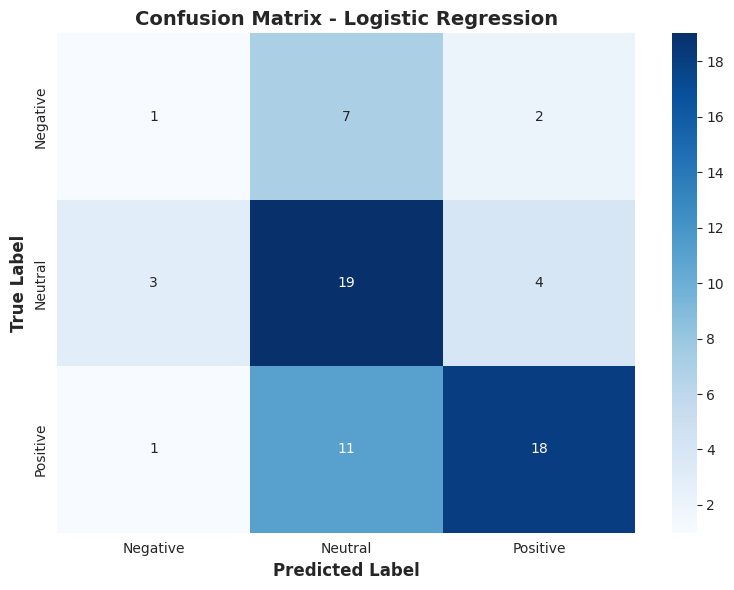

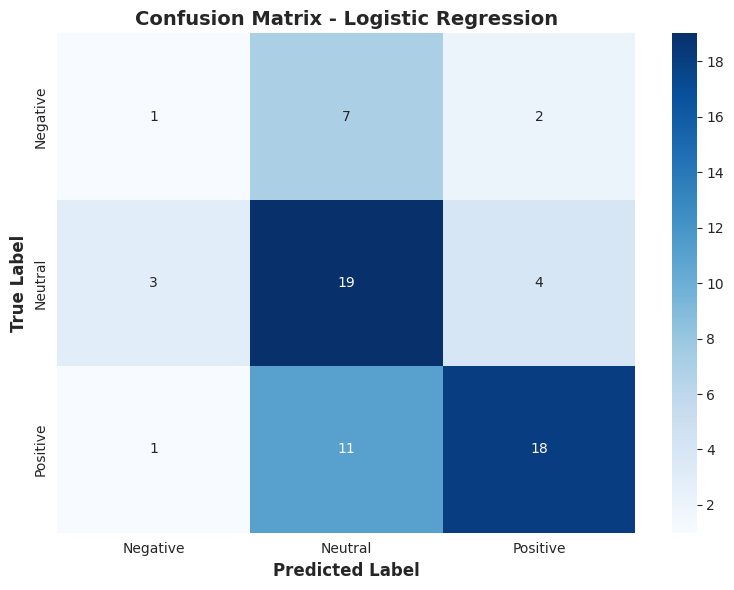

In [11]:
# Train Logistic Regression with hyperparameter tuning
lr_model, lr_grid_search = models.train_logistic_regression(X_train_tfidf, y_train)

# Evaluate on test set
lr_metrics = models.evaluate_model(lr_model, X_test_tfidf, y_test, "Logistic Regression")

# Plot confusion matrix
models.plot_confusion_matrix(
    y_test, 
    lr_model.predict(X_test_tfidf), 
    "Logistic Regression",
    save_path=utils.get_outputs_path('figures/lr_confusion_matrix.png')
)

## 6. Train Multinomial Naive Bayes


=== Training Multinomial Naive Bayes ===

Performing hyperparameter tuning...
✓ Best parameters: {'alpha': 1.0, 'fit_prior': True}
✓ Best CV accuracy: 0.6085

=== Evaluating Multinomial Naive Bayes ===

Accuracy:  0.5455
Precision: 0.5450
Recall:    0.5455
F1-Score:  0.5338

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.20      0.29        10
           1       0.48      0.58      0.53        26
           2       0.61      0.63      0.62        30

    accuracy                           0.55        66
   macro avg       0.53      0.47      0.48        66
weighted avg       0.54      0.55      0.53        66

✓ Confusion matrix saved to: /home/emmanuelabayor/projects/analisis-sentiment-pelatih-baru-chelsea-liam-rosenior/outputs/figures/nb_confusion_matrix.png


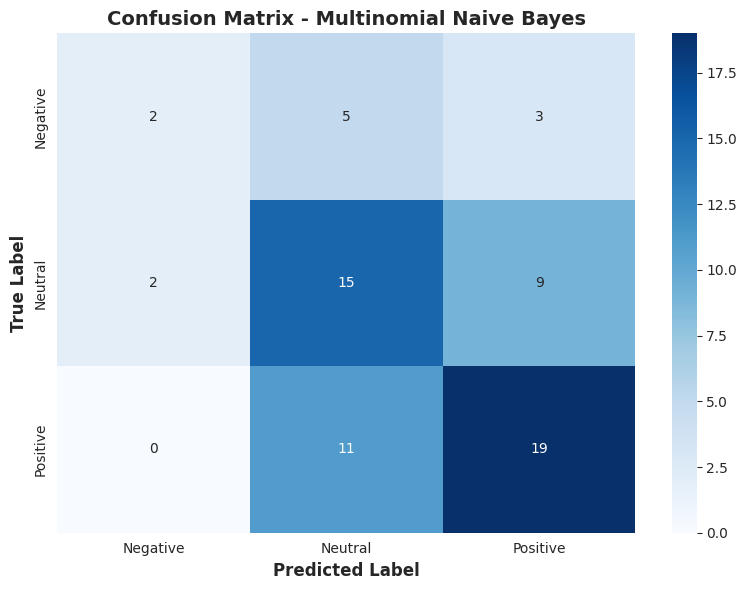

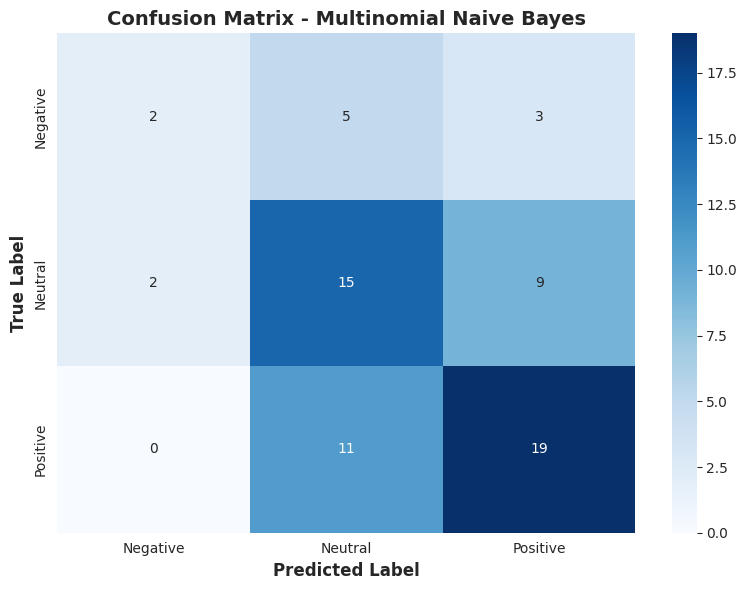

In [12]:
# Train Naive Bayes with hyperparameter tuning
nb_model, nb_grid_search = models.train_naive_bayes(X_train_count, y_train)

# Evaluate on test set
nb_metrics = models.evaluate_model(nb_model, X_test_count, y_test, "Multinomial Naive Bayes")

# Plot confusion matrix
models.plot_confusion_matrix(
    y_test, 
    nb_model.predict(X_test_count), 
    "Multinomial Naive Bayes",
    save_path=utils.get_outputs_path('figures/nb_confusion_matrix.png')
)

## 7. Compare Model Performance


=== Model Comparison ===

                  model  accuracy  precision  recall  f1_score
    Logistic Regression    0.5758     0.5735  0.5758    0.5608
Multinomial Naive Bayes    0.5455     0.5450  0.5455    0.5338

✓ Best Model: Logistic Regression (Accuracy: 0.5758)
✓ Model comparison plot saved to: /home/emmanuelabayor/projects/analisis-sentiment-pelatih-baru-chelsea-liam-rosenior/outputs/figures/model_comparison.png


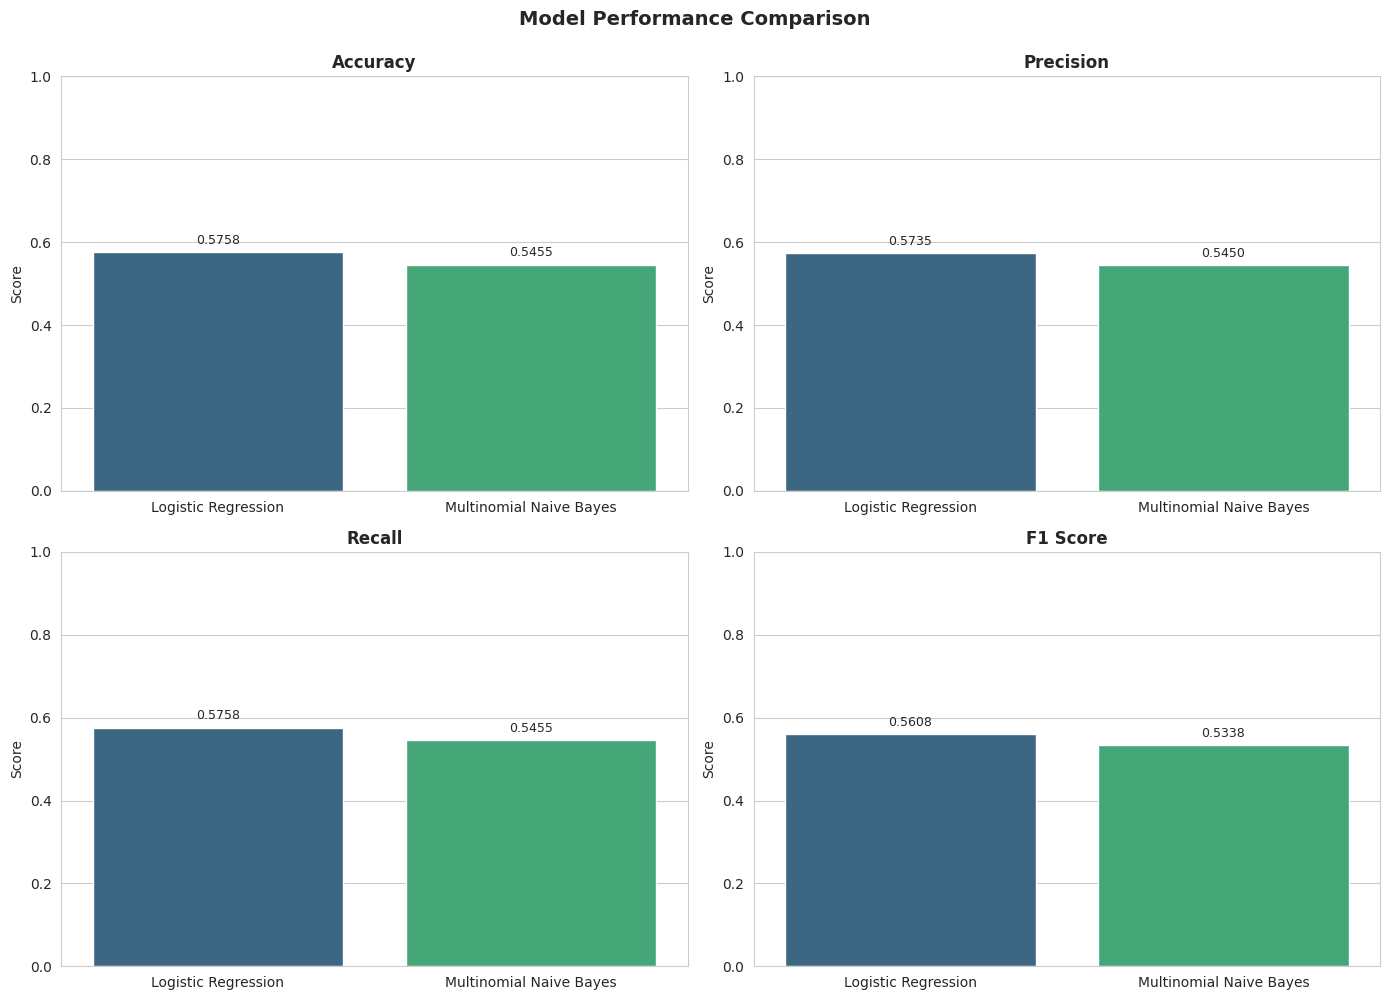

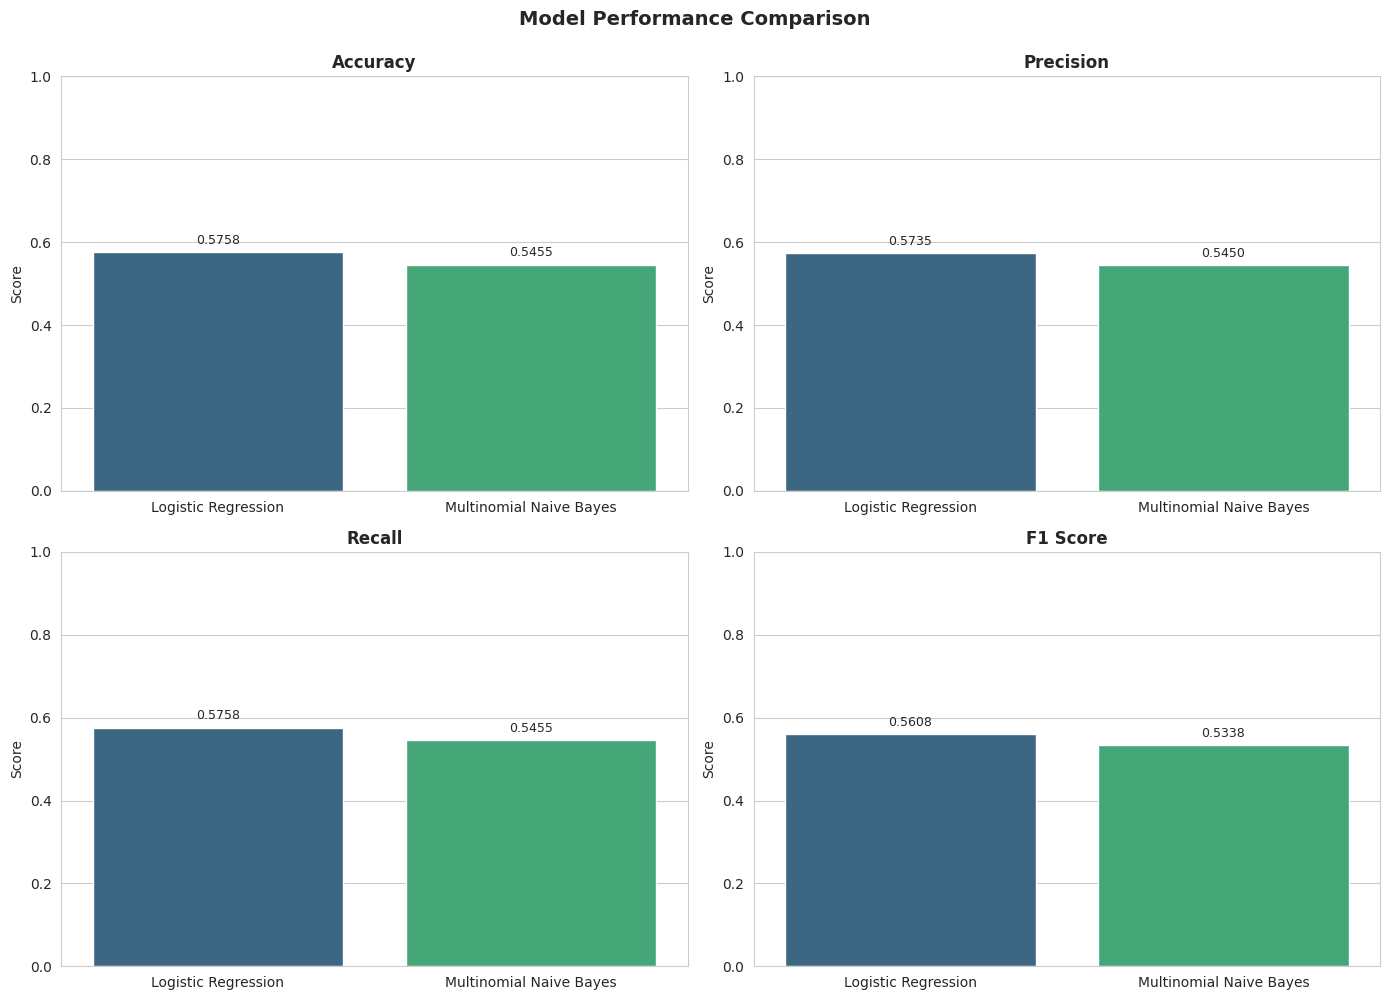

In [13]:
# Compare models
comparison_df = models.compare_models([lr_metrics, nb_metrics])

# Plot comparison
models.plot_model_comparison(
    comparison_df,
    save_path=utils.get_outputs_path('figures/model_comparison.png')
)

## 8. Feature Importance Analysis

Extracting top 20 important features...
✓ Top features extracted


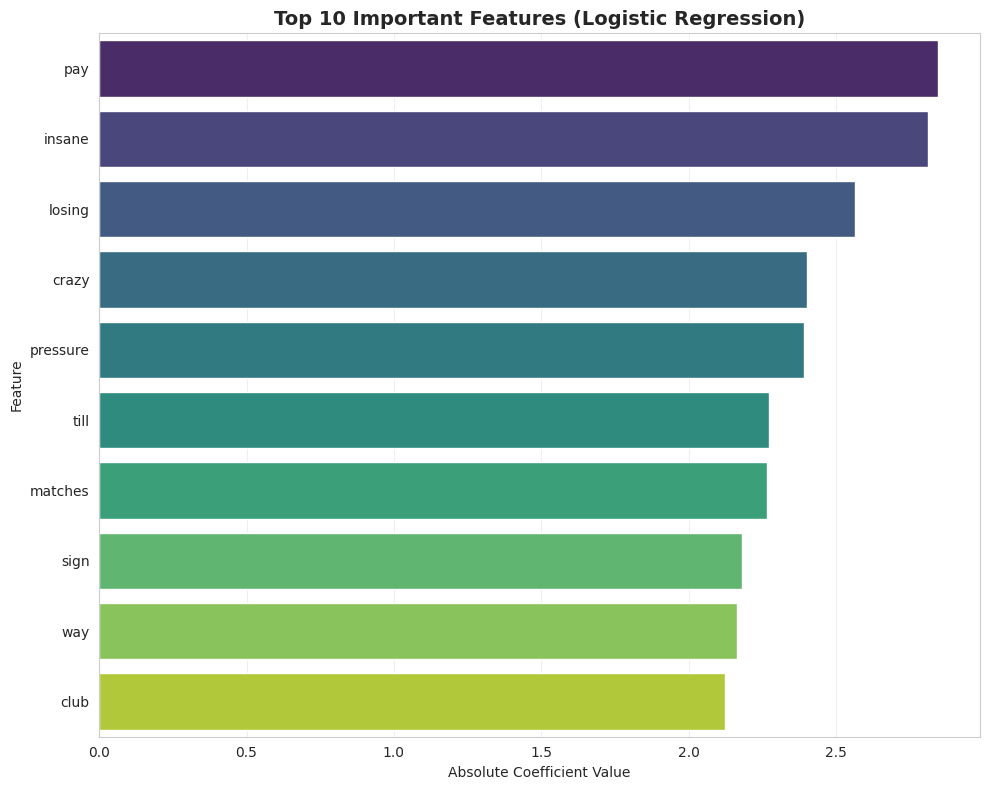


✓ Feature importance plot saved

Top 10 features:
 feature  importance
     pay    2.846192
  insane    2.811344
  losing    2.565517
   crazy    2.400370
pressure    2.391030
    till    2.273956
 matches    2.265545
    sign    2.182276
     way    2.165139
    club    2.122199


In [16]:
# Get top features for Logistic Regression
top_features_lr = feature_engineering.get_feature_importance(
    tfidf_vectorizer, 
    lr_model, 
    n_top=20
)

if top_features_lr is not None:
    # Plot top features
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.barplot(
    x='importance',
    y='feature',
    hue='feature',
    data=top_features_lr.head(10),
    palette='viridis',
    legend=False,
    ax=ax
    )
    ax.set_title('Top 10 Important Features (Logistic Regression)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Absolute Coefficient Value')
    ax.set_ylabel('Feature')
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig(utils.get_outputs_path('figures/feature_importance.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print("\n✓ Feature importance plot saved")
    print("\nTop 10 features:")
    print(top_features_lr.head(10).to_string(index=False))

## 9. Save Trained Models

In [17]:
# Save models
models.save_model(lr_model, 'logistic_regression', save_dir=utils.get_outputs_path('models'))
models.save_model(nb_model, 'naive_bayes', save_dir=utils.get_outputs_path('models'))

# Save vectorizers
import joblib
joblib.dump(tfidf_vectorizer, utils.get_outputs_path('models/tfidf_vectorizer.pkl'))
joblib.dump(count_vectorizer, utils.get_outputs_path('models/count_vectorizer.pkl'))

print("\n✓ Vectorizers saved")

✓ Model saved to: /home/emmanuelabayor/projects/analisis-sentiment-pelatih-baru-chelsea-liam-rosenior/outputs/models/logistic_regression.pkl
✓ Model saved to: /home/emmanuelabayor/projects/analisis-sentiment-pelatih-baru-chelsea-liam-rosenior/outputs/models/naive_bayes.pkl

✓ Vectorizers saved


## 10. Save Metrics

In [18]:
# Save metrics to JSON
models.save_metrics([lr_metrics, nb_metrics], save_dir=utils.get_outputs_path('metrics'))

# Save comparison table to CSV
comparison_df.to_csv(utils.get_outputs_path('tables/model_comparison.csv'), index=False)

print(f"\n✓ Model comparison saved to outputs/tables/model_comparison.csv")

✓ Metrics saved to: /home/emmanuelabayor/projects/analisis-sentiment-pelatih-baru-chelsea-liam-rosenior/outputs/metrics/metrics.json

✓ Model comparison saved to outputs/tables/model_comparison.csv


## 11. Model Performance Summary

In [19]:
# Display final summary
print("\n" + "="*60)
print("MACHINE LEARNING MODELING SUMMARY")
print("="*60)

print(f"\nDataset:")
print(f"  - Total tweets: {len(df)}")
print(f"  - Training set: {len(X_train)}")
print(f"  - Test set: {len(X_test)}")

print(f"\nSentiment Distribution:")
for label, code in label_map.items():
    count = (y_encoded == code).sum()
    print(f"  - {label}: {count} ({count/len(y_encoded)*100:.1f}%)")

print(f"\nModel Performance:")
print(f"{'='*60}")
print(comparison_df.to_string(index=False))
print(f"{'='*60}")

# Determine best model
best_model = comparison_df.iloc[0]
print(f"\n✓ Best Model: {best_model['model']}")
print(f"  - Accuracy: {best_model['accuracy']:.4f}")
print(f"  - F1-Score: {best_model['f1_score']:.4f}")


MACHINE LEARNING MODELING SUMMARY

Dataset:
  - Total tweets: 329
  - Training set: 263
  - Test set: 66

Sentiment Distribution:
  - Negative: 48 (14.6%)
  - Neutral: 131 (39.8%)
  - Positive: 150 (45.6%)

Model Performance:
                  model  accuracy  precision  recall  f1_score
    Logistic Regression    0.5758     0.5735  0.5758    0.5608
Multinomial Naive Bayes    0.5455     0.5450  0.5455    0.5338

✓ Best Model: Logistic Regression
  - Accuracy: 0.5758
  - F1-Score: 0.5608


## ✅ ML Modeling Complete!

**Summary:**
- Trained 2 models: Logistic Regression and Multinomial Naive Bayes
- Used TF-IDF for LR and CountVectorizer for NB
- Applied hyperparameter tuning with GridSearchCV
- Evaluated models using accuracy, precision, recall, F1-score

**Models Saved:**
- `logistic_regression.pkl`
- `naive_bayes.pkl`
- `tfidf_vectorizer.pkl`
- `count_vectorizer.pkl`

**Visualizations Saved:**
- `lr_confusion_matrix.png`
- `nb_confusion_matrix.png`
- `model_comparison.png`
- `feature_importance.png`

**Tables Saved:**
- `model_comparison.csv`
- `metrics.json`

**Next Steps:**

→ **`5_results_visualization.ipynb`** - Export final visualizations for report